<a href="https://colab.research.google.com/github/npetitclerc/EnergyDataSimulationChallenge/blob/master/nicolas/projects/K5/Identify_cell_level_K5_losses_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Try to quantify how much data we are lossing from the K5 at cell level.

In this notebook we use the raw numbers - before Unacast do any filtering.

In [0]:
import pandas as pd

In [0]:
query = """
  SELECT hour,	cell_id AS global_cell_id,	unique_imsis AS counts,	num_signals FROM `telia-ddi-no-dev.intermediate_output.signals_count_20200110`
  ORDER BY
    counts
  """

In [3]:
df = pd.read_gbq(query, project_id='telia-ddi-no-dev')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=c7gEQiNE0qpgiTM7b2YNsuV4ktxQfL&prompt=consent&access_type=offline
Enter the authorization code: 4/wQHQ0oZs3R-pCEO7UkVlzHHQcOHKDgeu47bPhtNQoiOzrQaKcZzb0ko


In [4]:
df

,hour,global_cell_id,counts,num_signals
0,0,1603,5,24
1,0,132689012,5,7
2,0,21193,5,10
3,0,34099725,5,62
4,0,130097021,5,5
...,...,...,...,...
1847293,18,0,300950,615948
1847294,10,0,302288,637358
1847295,9,0,354975,689398
1847296,7,0,369551,669472


In [0]:
import pylab as plt
import seaborn as sns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa948b4df60>]],
      dtype=object)

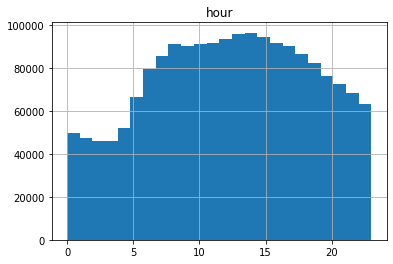

In [6]:
df.hist('hour', bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa948163cf8>]],
      dtype=object)

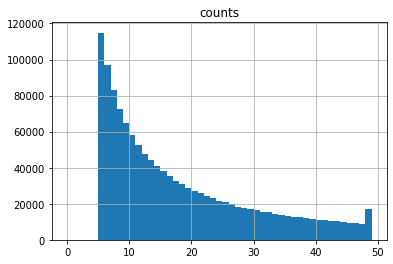

In [7]:
import numpy as np
df.hist('counts', bins=range(50))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa94805f3c8>]],
      dtype=object)

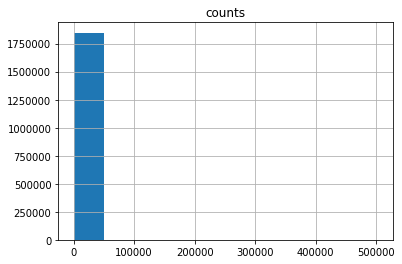

In [8]:
df.hist('counts')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa947fff828>]],
      dtype=object)

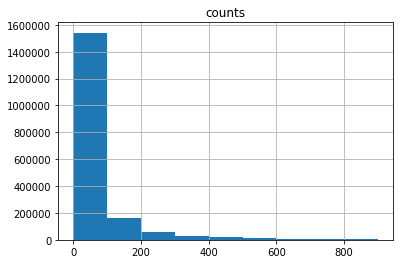

In [9]:
df.hist('counts', bins=np.array(range(10))*100)

# Add zero counts

In [10]:
import numpy as np
from ast import literal_eval

zeros = pd.DataFrame({'global_cell_id':df.global_cell_id.unique()})
zeros.insert(1, 'hour', str(list(range(24))))
zeros['hour'] = zeros['hour'].apply(lambda x: literal_eval(x))
zeros = zeros.explode('hour')
zeros['counts'] = 0
zeros

,global_cell_id,hour,counts
0,1603,0,0
0,1603,1,0
0,1603,2,0
0,1603,3,0
0,1603,4,0
...,...,...,...
103740,33666571,19,0
103740,33666571,20,0
103740,33666571,21,0
103740,33666571,22,0


In [11]:
dfz = pd.merge(df, zeros, how='right', on=['global_cell_id', 'hour']).fillna(0)
dfz['counts'] = dfz['counts_x'] + dfz['counts_y']
dfz

,hour,global_cell_id,counts_x,num_signals,counts_y,counts
0,0.0,1603,5.0,24.0,0,5.0
1,0.0,132689012,5.0,7.0,0,5.0
2,0.0,21193,5.0,10.0,0,5.0
3,0.0,34099725,5.0,62.0,0,5.0
4,0.0,130097021,5.0,5.0,0,5.0
...,...,...,...,...,...,...
2554482,4.0,34659085,0.0,0.0,0,0.0
2554483,5.0,34659085,0.0,0.0,0,0.0
2554484,6.0,34659085,0.0,0.0,0,0.0
2554485,7.0,34659085,0.0,0.0,0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa947f81710>]],
      dtype=object)

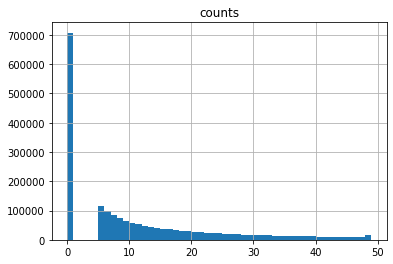

In [12]:
dfz.hist('counts', bins=range(50))

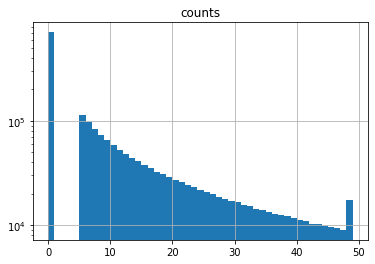

In [13]:
dfz.hist('counts', bins=range(50))
plt.yscale('log')

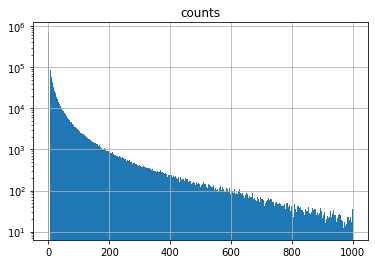

In [14]:
dfz.hist('counts', bins=range(1000))
plt.yscale('log')
#plt.xscale('log')

# Extrapolate to zero

In [0]:
h = np.histogram(dfz['counts'], bins=range(1000))

In [95]:
from scipy.optimize import curve_fit

y = h[0][5:100]#999]
x = h[1][5:100]#999]

# Add a fictive point to control the model on the top
x = [0] + list(x) 
y = [165000] + list(y) 

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

sol1 = np.poly1d(np.polyfit(x, y, 10))
sol2 = curve_fit(func_powerlaw, x, y, p0 = np.asarray([-1,10**5,0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in reciprocal
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [96]:
s1 = sol1(x)
s2 = func_powerlaw(x, *sol2[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


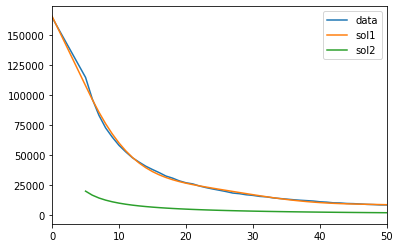

In [97]:
plt.plot(x, y, label='data')
plt.plot(x, s1, label='sol1')
plt.plot(x, s2, label='sol2')
plt.xlim([0, 50])
plt.legend()

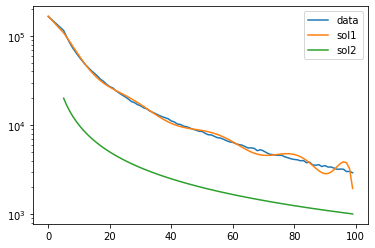

In [98]:
plt.plot(x, y, label='data')
plt.plot(x, s1, label='sol1')
plt.plot(x, s2, label='sol2')
#plt.xlim([0, 50])
plt.yscale('log')
plt.legend()

In [99]:
x_ = list(range(100))# + list(x)
s2 = func_powerlaw(x_, *sol2[0])
#print(x_[:30])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


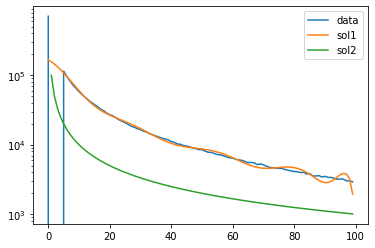

In [100]:
y = h[0][:100]
x = h[1][:100]

plt.plot(x, y, label='data')
plt.plot(x_, sol1(x_), label='sol1')
plt.plot(x_, s2, label='sol2')
#plt.xlim([0, 100])
plt.yscale('log')
#plt.xscale('log')
plt.legend()

In [101]:
cumsum_ext1, cumsum_ext2, cumsum_real = 0, 0, 0
for i in range(4):
  #cumsum_real += y[i+1] * (i+1)
  cumsum_ext2 += s2[i+1] * (i+1)
  cumsum_ext1 += sol1(i+1) * (i+1)
#print("cumsum_real:", cumsum_real)
print("cumsum_ext1:", cumsum_ext1)
print("cumsum_ext2:", cumsum_ext2)
#print("cumsum_diff1:", cumsum_ext1 - cumsum_real)
#print("cumsum_diff1 (%):", cumsum_real /cumsum_ext1)

#print("cumsum_diff2:", cumsum_ext2 - cumsum_real)
#print("cumsum_diff2 (%):", cumsum_real /cumsum_ext2)


cumsum_ext1: 1324330.1817979515
cumsum_ext2: 400000.0


In [102]:
print("Total cell/h set to 0:", y[0])
print("Cummulative sum of cell/h from model1: ", sol1(0)  + sol1(1) + sol1(2) + sol1(3)  + sol1(4))
print("Estimated K-5ed cell/h from model1: ", sol1(1) + sol1(2) + sol1(3)  + sol1(4))

Total cell/h set to 0: 707189
Cummulative sum of cell/h from model1:  719752.8567100675
Estimated K-5ed cell/h from model1:  553850.4327156595


## Cell/h analysis

In [103]:
sum(h[0][1:])

1842123

In [104]:
print("Check that the total cell_id/h add up")
sum(h[0]) / 103741 / 24

Check that the total cell_id/h add up


1.023908901334413

In [105]:
print("Unique cell_ids: ",len(df.global_cell_id.unique()))

Unique cell_ids:  103741


In [106]:
print("Equivalent of hour lost: ", 553850 / 103741)

Equivalent of hour lost:  5.338776375781996


In [107]:
print("% of loss cell/h: ", 553850 / (103741 * 24) * 100)

% of loss cell/h:  22.244901565758315


## Unique IMSI analysis

In [110]:
unique_imsi = 1742722 # distinct identifiers from the activity table on 20200110
total_unique_imsi_lost = sol1(1) + sol1(2) * 2 + sol1(3) * 3 + sol1(4) * 4
print("total unique imsi lost: ", total_unique_imsi_lost)
print("Average per hour - unique imsi lost: ", total_unique_imsi_lost / 24.)
print("Average per hour - % unique imsi lost: ", total_unique_imsi_lost / 24./ unique_imsi * 100)


total unique imsi lost:  1324330.1817979515
Average per hour - unique imsi lost:  55180.42424158131
Average per hour - % unique imsi lost:  3.1663354362647236


# AM

In [0]:
dfz_am = dfz[(dfz['hour'] >= 1) & (dfz['hour'] <= 4)]
dfz_pm = dfz[(dfz['hour'] >= 13) & (dfz['hour'] <= 16)]

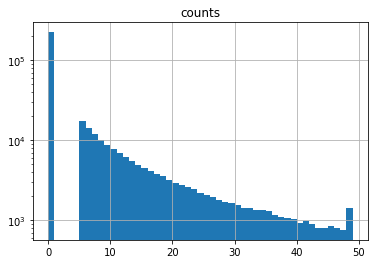

In [137]:
dfz_am.hist('counts', bins=range(50))
plt.yscale('log')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in reciprocal
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


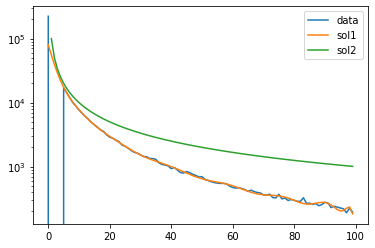

In [138]:
h_am = np.histogram(dfz_am['counts'], bins=range(1000))
y = h_am[0][5:100]#999]
x = h_am[1][5:100]#999]

# Add a fictive point to control the model on the top
x = [0] + list(x) 
y = [80000] + list(y) 

sol1 = np.poly1d(np.polyfit(x, y, 15))
sol2 = curve_fit(func_powerlaw, x, y, p0 = np.asarray([-1,10**5,0]))

# Extrapolate to 0
x_ = list(range(100)) # + list(x)
s2 = func_powerlaw(x_, *sol2[0])

y = h_am[0][:100]
x = h_am[1][:100]

plt.plot(x, y, label='data')
plt.plot(x_, sol1(x_), label='sol1')
plt.plot(x_, s2, label='sol2')
#plt.xlim([0, 100])
plt.yscale('log')
#plt.xscale('log')
plt.legend()

In [139]:
cumsum_ext1_am, cumsum_ext2_am, cumsum_real = 0, 0, 0
for i in range(4):
  #cumsum_real += y[i+1] * (i+1)
  cumsum_ext2_am += s2[i+1] * (i+1)
  cumsum_ext1_am += sol1(i+1) * (i+1)
#print("cumsum_real:", cumsum_real)
#print("Missing cells:")
print("cumsum_ext1:", cumsum_ext1_am)
print("cumsum_ext2:", cumsum_ext2_am)
#print("cumsum_diff1:", cumsum_ext1 - cumsum_real)
#print("cumsum_diff1 (%):", cumsum_real /cumsum_ext1)

#print("cumsum_diff2:", cumsum_ext2 - cumsum_real)
#print("cumsum_diff2 (%):", cumsum_real /cumsum_ext2)

cumsum_ext1: 308574.59208808123
cumsum_ext2: 400000.0


In [140]:
print("Total cell/h set to 0:", y[0])
print("Cummulative sum of cell/h from model1: ", sol1(0)  + sol1(1) + sol1(2) + sol1(3)  + sol1(4))
#print("Cummulative sum of cell/h from model2: ", sol2(0)  + sol2(1) + sol2(2) + sol2(3)  + sol2(4))

Total cell/h set to 0: 223238
Cummulative sum of cell/h from model1:  225679.37028495184


In [141]:
print("Total cell/h set to 0:", y[0])
print("Cummulative sum of cell/h from model1: ", sol1(0)  + sol1(1) + sol1(2) + sol1(3)  + sol1(4))
print("Estimated K-5ed cell/h from model1: ", sol1(1) + sol1(2) + sol1(3)  + sol1(4))

Total cell/h set to 0: 223238
Cummulative sum of cell/h from model1:  225679.37028495184
Estimated K-5ed cell/h from model1:  145682.00108931883


## Cell/h analysis

In [142]:
sum(h_am[0][1:])

191799

In [143]:
print("Check that the total cell_id/h add up")
sum(h_am[0]) / 103741 / 4

Check that the total cell_id/h add up


1.0001759188748904

In [144]:
print("Unique cell_ids: ",len(df.global_cell_id.unique()))

Unique cell_ids:  103741


In [145]:
print("Equivalent of hour lost: ", (sol1(1) + sol1(2) + sol1(3)  + sol1(4)) / 103741)

Equivalent of hour lost:  1.4042856834744106


In [146]:
print("% of loss cell/h: ", (sol1(1) + sol1(2) + sol1(3)  + sol1(4)) / (103741 * 4) * 100)

% of loss cell/h:  35.107142086860264


## Unique IMSI analysis

In [147]:
total_unique_imsi_lost_am = sol1(1) + sol1(2) * 2 + sol1(3) * 3 + sol1(4) * 4
print("AM total unique imsi lost: ", total_unique_imsi_lost_am)
print("AM Average per hour - unique imsi lost: ", total_unique_imsi_lost_am / 4.)
print("Average per hour - % unique imsi lost: ", total_unique_imsi_lost_am / 4./ unique_imsi * 100)

AM total unique imsi lost:  308574.59208808123
AM Average per hour - unique imsi lost:  77143.64802202031
Average per hour - % unique imsi lost:  4.426618130833277


# PM

In [0]:
dfz_pm = dfz[(dfz['hour'] >= 13) & (dfz['hour'] <= 16)]

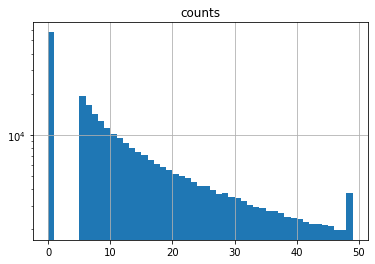

In [124]:
dfz_pm.hist('counts', bins=range(50))
plt.yscale('log')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in reciprocal
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


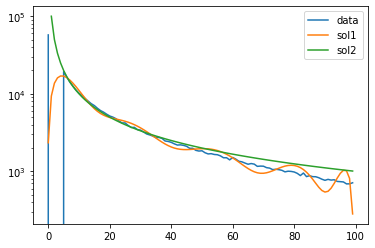

In [125]:
h_pm = np.histogram(dfz_pm['counts'], bins=range(1000))
y = h_pm[0][5:100]#999]
x = h_pm[1][5:100]#999]

# Add a fictive point to control the model on the top
x = [0] + list(x) 
y = [2000] + list(y) 

sol1 = np.poly1d(np.polyfit(x, y, 10))
sol2 = curve_fit(func_powerlaw, x, y, p0 = np.asarray([-1,10**5,0]))

# Extrapolate to 0
x_ = list(range(100)) #+ list(x)
s2 = func_powerlaw(x_, *sol2[0])

y = h_pm[0][:100]
x = h_pm[1][:100]

plt.plot(x, y, label='data')
plt.plot(x_, sol1(x_), label='sol1')
plt.plot(x_, s2, label='sol2')
#plt.xlim([0, 100])
plt.yscale('log')
#plt.xscale('log')
plt.legend()

In [126]:
cumsum_ext1_pm, cumsum_ext2_pm, cumsum_real = 0, 0, 0
for i in range(4):
  #cumsum_real += y[i+1] * (i+1)
  cumsum_ext2_pm += s2[i+1] * (i+1)
  cumsum_ext1_pm += sol1(i+1) * (i+1)
#print("cumsum_real:", cumsum_real)
print("cumsum_ext1:", cumsum_ext1_pm)
print("cumsum_ext2:", cumsum_ext2_pm)
#print("cumsum_diff1:", cumsum_ext1 - cumsum_real)
#print("cumsum_diff1 (%):", cumsum_real /cumsum_ext1)

#print("cumsum_diff2:", cumsum_ext2 - cumsum_real)
#print("cumsum_diff2 (%):", cumsum_real /cumsum_ext2)

cumsum_ext1: 152845.4841632042
cumsum_ext2: 400000.0


In [127]:
print("Total cell/h set to 0:", y[0])
print("Cummulative sum of cell/h from model1: ", sol1(0)  + sol1(1) + sol1(2) + sol1(3)  + sol1(4))
#print("Cummulative sum of cell/h from model2: ", s2[0]  + s2[1] + s2[2] + s2[3]  + s2[4])

Total cell/h set to 0: 57453
Cummulative sum of cell/h from model1:  58435.200331938315


In [128]:
print("Total cell/h set to 0:", y[0])
print("Cummulative sum of cell/h from model1: ", sol1(0)  + sol1(1) + sol1(2) + sol1(3)  + sol1(4))
print("Estimated K-5ed cell/h from model1: ", sol1(1) + sol1(2) + sol1(3)  + sol1(4))

Total cell/h set to 0: 57453
Cummulative sum of cell/h from model1:  58435.200331938315
Estimated K-5ed cell/h from model1:  56096.591397805234


## Cell/h analysis

In [129]:
print("Unique cell_ids: ",len(df.global_cell_id.unique()))
sum(h_pm[0][1:])

Unique cell_ids:  103741


375201

In [130]:
print("Check that the total cell_id/h add up PM")
sum(h_pm[0]) / 103741 / 4

Check that the total cell_id/h add up PM


1.0426302040658948

In [131]:
print("PM Equivalent of hour lost: ", (sol1(1) + sol1(2) + sol1(3)  + sol1(4)) / 103741)

PM Equivalent of hour lost:  0.5407369448704489


In [132]:
print("% of loss cell/h: ", (sol1(1) + sol1(2) + sol1(3)  + sol1(4)) / (103741 * 4) * 100)

% of loss cell/h:  13.518423621761222


## Unique IMSI analysis

In [135]:
total_unique_imsi_lost_pm = sol1(1) + sol1(2) * 2 + sol1(3) * 3 + sol1(4) * 4
print("PM total unique imsi lost: ", total_unique_imsi_lost_pm)
print("PM Average per hour - unique imsi lost: ", total_unique_imsi_lost_pm / 4.)
print("Average per hour - % unique imsi lost: ", total_unique_imsi_lost_pm / 4./ unique_imsi * 100)

PM total unique imsi lost:  152845.4841632042
PM Average per hour - unique imsi lost:  38211.37104080105
Average per hour - % unique imsi lost:  2.192625733811879


In [134]:
sol1(0)

2338.6089341330853

#Conclusions:

From 1 day of data - there were around:
- 707,189 - Cells/h without any pings
- ~553,850 - Cells/h were removed from K-5
- **That's the equivalent of over 5h blackout!** (for 103,741 cell_ids)
- or a 22% cell/h loss
- Unique imsi lost (Average per hour): 55,180
- % unique imsi lost (Average per hour):  3.16

AM vs PM:

Metric | AM | PM
--- | --- | ---
Equivalent of hour lost (out of 4) | 1.4 | 0.54
Cells/h removed from K-5 | 145,682 | 56,097
**% of lost cell/h**  | **35.1** | **13.5**
Unique imsi lost (Average per hour) | 77,144 | 38,211
% unique imsi lost (Average per hour) | 4.42 | 2.2



